In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

2023-12-16 05:26:31.018055: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow.keras.preprocessing.image import load_img

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Add Image Exploration

### Using Xception

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [5]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2023-12-12 14:14:07.934901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-12 14:14:07.941695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-12 14:14:07.942334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-12 14:14:07.943237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

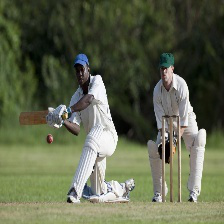

In [4]:
path = '../data/train/cricket'
name = '050.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [5]:
img = load_img(fullname, target_size=(299,299))

In [6]:
x = np.array(img)

In [7]:
x.shape

(299, 299, 3)

In [10]:
X = np.array([x])
X = preprocess_input(X)

In [11]:
pred = model.predict(X)

2023-12-12 14:14:11.154223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-12 14:14:11.770040: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-12 14:14:11.770502: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-12 14:14:11.770536: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-12 14:14:11.771108: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-12 14:14:11.771183: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 2s 2s/step


In [12]:
decode_predictions(pred)

[[('n02799071', 'baseball', 0.44192117),
  ('n09835506', 'ballplayer', 0.4017308),
  ('n03134739', 'croquet_ball', 0.018669732),
  ('n03445777', 'golf_ball', 0.012821494),
  ('n04254680', 'soccer_ball', 0.0039377543)]]

Of the bat, Xception does not do a very good job at classifying the images correctly. We need to improve our model.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(150, 150),
    batch_size=32
)

Found 13492 images belonging to 100 classes.


In [15]:
train_ds.class_indices

{'air hockey': 0,
 'ampute football': 1,
 'archery': 2,
 'arm wrestling': 3,
 'axe throwing': 4,
 'balance beam': 5,
 'barell racing': 6,
 'baseball': 7,
 'basketball': 8,
 'baton twirling': 9,
 'bike polo': 10,
 'billiards': 11,
 'bmx': 12,
 'bobsled': 13,
 'bowling': 14,
 'boxing': 15,
 'bull riding': 16,
 'bungee jumping': 17,
 'canoe slamon': 18,
 'cheerleading': 19,
 'chuckwagon racing': 20,
 'cricket': 21,
 'croquet': 22,
 'curling': 23,
 'disc golf': 24,
 'fencing': 25,
 'field hockey': 26,
 'figure skating men': 27,
 'figure skating pairs': 28,
 'figure skating women': 29,
 'fly fishing': 30,
 'football': 31,
 'formula 1 racing': 32,
 'frisbee': 33,
 'gaga': 34,
 'giant slalom': 35,
 'golf': 36,
 'hammer throw': 37,
 'hang gliding': 38,
 'harness racing': 39,
 'high jump': 40,
 'hockey': 41,
 'horse jumping': 42,
 'horse racing': 43,
 'horseshoe pitching': 44,
 'hurdles': 45,
 'hydroplane racing': 46,
 'ice climbing': 47,
 'ice yachting': 48,
 'jai alai': 49,
 'javelin': 50,
 '

In [16]:
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    '../data/valid',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 500 images belonging to 100 classes.


### Training a Base Model

In [21]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(100)(vectors)

model = keras.Model(inputs, outputs)

We will start with a learning rate of 0.01.

#### With Adam Optimizer

In [22]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
import scipy

In [23]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
422/422 [==============================] - 27s 59ms/step - loss: 3.2502 - accuracy: 0.5546 - val_loss: 2.5616 - val_accuracy: 0.6940
Epoch 2/10
422/422 [==============================] - 23s 55ms/step - loss: 1.5022 - accuracy: 0.7701 - val_loss: 2.4919 - val_accuracy: 0.7520
Epoch 3/10
422/422 [==============================] - 24s 56ms/step - loss: 1.0401 - accuracy: 0.8335 - val_loss: 2.6202 - val_accuracy: 0.7520
Epoch 4/10
422/422 [==============================] - 23s 55ms/step - loss: 0.8445 - accuracy: 0.8595 - val_loss: 2.2602 - val_accuracy: 0.7700
Epoch 5/10
422/422 [==============================] - 24s 56ms/step - loss: 0.6010 - accuracy: 0.8967 - val_loss: 3.3788 - val_accuracy: 0.7500
Epoch 6/10
422/422 [==============================] - 23s 55ms/step - loss: 0.5668 - accuracy: 0.9097 - val_loss: 2.7041 - val_accuracy: 0.7780
Epoch 7/10
422/422 [==============================] - 23s 56ms/step - loss: 0.4814 - accuracy: 0.9175 - val_loss: 2.7817 - val_accuracy:

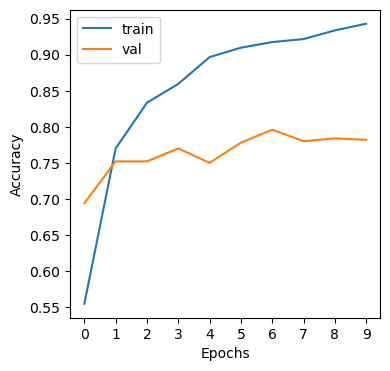

In [26]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We see that there is clear overfitting in the model, and also the model doesn't do too well on validation set.

#### With SGD

In [29]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150,150,3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(100)(vectors)

model = keras.Model(inputs, outputs)

In [30]:
learning_rate = 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [31]:
history_sgd = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
422/422 [==============================] - 26s 57ms/step - loss: 3.3550 - accuracy: 0.3004 - val_loss: 2.2421 - val_accuracy: 0.5540
Epoch 2/10
422/422 [==============================] - 24s 56ms/step - loss: 1.9516 - accuracy: 0.5984 - val_loss: 1.5463 - val_accuracy: 0.6820
Epoch 3/10
422/422 [==============================] - 24s 56ms/step - loss: 1.4865 - accuracy: 0.6788 - val_loss: 1.2606 - val_accuracy: 0.7280
Epoch 4/10
422/422 [==============================] - 23s 56ms/step - loss: 1.2566 - accuracy: 0.7192 - val_loss: 1.1112 - val_accuracy: 0.7340
Epoch 5/10
422/422 [==============================] - 23s 56ms/step - loss: 1.1166 - accuracy: 0.7400 - val_loss: 1.0087 - val_accuracy: 0.7580
Epoch 6/10
422/422 [==============================] - 24s 56ms/step - loss: 1.0159 - accuracy: 0.7607 - val_loss: 0.9441 - val_accuracy: 0.7720
Epoch 7/10
422/422 [==============================] - 24s 56ms/step - loss: 0.9393 - accuracy: 0.7756 - val_loss: 0.8940 - val_accuracy:

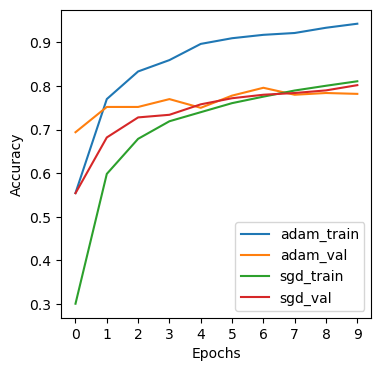

In [32]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'], label='adam_train')
plt.plot(history.history['val_accuracy'], label='adam_val')
plt.plot(history_sgd.history['accuracy'], label='sgd_train')
plt.plot(history_sgd.history['val_accuracy'], label='sgd_val')
plt.xticks(np.arange(10))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The SGD Optimizer seems to be much more stable than Adam with slightly better accuracy on Validation set.

### Using MobileNetV2

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [22]:
# Create training set

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(224, 224),
    batch_size=32
)

# Create validation set

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    '../data/valid',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [23]:
model_mv2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model_mv2.trainable = False

inputs = keras.Input(shape=(224,224,3))

base = model_mv2(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(100)(vectors)

model = keras.Model(inputs, outputs)

In [38]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history_mv2_adam = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
422/422 [==============================] - 30s 64ms/step - loss: 1.7471 - accuracy: 0.7015 - val_loss: 0.9150 - val_accuracy: 0.8280
Epoch 2/10
422/422 [==============================] - 26s 62ms/step - loss: 0.6226 - accuracy: 0.8829 - val_loss: 1.0079 - val_accuracy: 0.8540
Epoch 3/10
422/422 [==============================] - 25s 60ms/step - loss: 0.4165 - accuracy: 0.9215 - val_loss: 1.0233 - val_accuracy: 0.8700
Epoch 4/10
422/422 [==============================] - 26s 61ms/step - loss: 0.3140 - accuracy: 0.9387 - val_loss: 0.9323 - val_accuracy: 0.8820
Epoch 5/10
422/422 [==============================] - 24s 57ms/step - loss: 0.2372 - accuracy: 0.9518 - val_loss: 1.1052 - val_accuracy: 0.8720
Epoch 6/10
422/422 [==============================] - 25s 60ms/step - loss: 0.2927 - accuracy: 0.9497 - val_loss: 1.1701 - val_accuracy: 0.8800
Epoch 7/10
422/422 [==============================] - 25s 60ms/step - loss: 0.2744 - accuracy: 0.9555 - val_loss: 1.5228 - val_accuracy:

In [39]:
model_mv2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model_mv2.trainable = False

inputs = keras.Input(shape=(224,224,3))

base = model_mv2(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(100)(vectors)

model = keras.Model(inputs, outputs)

In [40]:
learning_rate = 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history_mv2_sgd = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
422/422 [==============================] - 29s 64ms/step - loss: 3.2605 - accuracy: 0.3303 - val_loss: 2.0183 - val_accuracy: 0.6280
Epoch 2/10
422/422 [==============================] - 27s 64ms/step - loss: 1.5485 - accuracy: 0.7241 - val_loss: 1.1609 - val_accuracy: 0.8060
Epoch 3/10
422/422 [==============================] - 27s 65ms/step - loss: 1.0239 - accuracy: 0.8148 - val_loss: 0.8568 - val_accuracy: 0.8440
Epoch 4/10
422/422 [==============================] - 27s 64ms/step - loss: 0.7955 - accuracy: 0.8515 - val_loss: 0.6936 - val_accuracy: 0.8680
Epoch 5/10
422/422 [==============================] - 28s 65ms/step - loss: 0.6635 - accuracy: 0.8744 - val_loss: 0.6045 - val_accuracy: 0.8700
Epoch 6/10
422/422 [==============================] - 27s 63ms/step - loss: 0.5773 - accuracy: 0.8896 - val_loss: 0.5410 - val_accuracy: 0.8900
Epoch 7/10
422/422 [==============================] - 28s 65ms/step - loss: 0.5148 - accuracy: 0.9034 - val_loss: 0.4894 - val_accuracy:

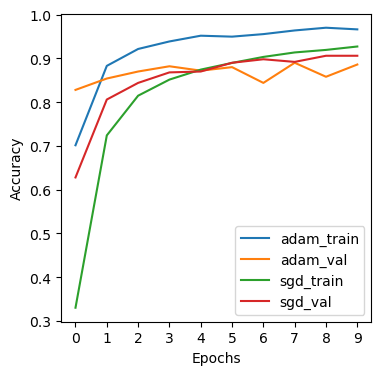

In [41]:
plt.figure(figsize=(4,4))
plt.plot(history_mv2_adam.history['accuracy'], label='adam_train')
plt.plot(history_mv2_adam.history['val_accuracy'], label='adam_val')
plt.plot(history_mv2_sgd.history['accuracy'], label='sgd_train')
plt.plot(history_mv2_sgd.history['val_accuracy'], label='sgd_val')
plt.xticks(np.arange(10))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Even with MobileNetV2, SGD seems to perform better than Adam. With, MobileNetV2 giving better accuracy than Xception which is a good thing given MobileNetV2 is a much lighter model than Xception. 

We will try with ResNet50 next to judge performance across 3 different pre-trained models.

### ResNet50

In [8]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

In [13]:
# Create training set

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(150, 150),
    batch_size=32
)

# Create validation set

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    '../data/valid',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [14]:
model_res = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model_res.trainable = False

inputs = keras.Input(shape=(150,150,3))

base = model_res(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(100)(vectors)

model = keras.Model(inputs, outputs)

In [15]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history_res_adam = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


2023-12-13 14:33:38.985620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-13 14:33:39.617017: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 14:33:39.617610: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 14:33:39.617644: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-13 14:33:39.618130: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 14:33:39.618200: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


422/422 [==============================] - 38s 79ms/step - loss: 5.9359 - accuracy: 0.5836 - val_loss: 3.2000 - val_accuracy: 0.7800
Epoch 2/10
422/422 [==============================] - 24s 57ms/step - loss: 2.6248 - accuracy: 0.7976 - val_loss: 3.1967 - val_accuracy: 0.8060
Epoch 3/10
422/422 [==============================] - 24s 58ms/step - loss: 2.0019 - accuracy: 0.8544 - val_loss: 3.5560 - val_accuracy: 0.8000
Epoch 4/10
422/422 [==============================] - 24s 57ms/step - loss: 1.3866 - accuracy: 0.8937 - val_loss: 3.5582 - val_accuracy: 0.8260
Epoch 5/10
422/422 [==============================] - 24s 58ms/step - loss: 1.4640 - accuracy: 0.8994 - val_loss: 4.1485 - val_accuracy: 0.8240
Epoch 6/10
422/422 [==============================] - 25s 59ms/step - loss: 1.1107 - accuracy: 0.9216 - val_loss: 3.9667 - val_accuracy: 0.8460
Epoch 7/10
422/422 [==============================] - 25s 59ms/step - loss: 0.9528 - accuracy: 0.9289 - val_loss: 3.7465 - val_accuracy: 0.8540
Epo

In [16]:
model_res = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

model_res.trainable = False

inputs = keras.Input(shape=(150,150,3))

base = model_res(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(100)(vectors)

model = keras.Model(inputs, outputs)

In [17]:
learning_rate = 0.01
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history_res_sgd = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
422/422 [==============================] - 28s 60ms/step - loss: 1.9777 - accuracy: 0.5240 - val_loss: 0.7788 - val_accuracy: 0.7960
Epoch 2/10
422/422 [==============================] - 25s 58ms/step - loss: 0.7474 - accuracy: 0.8043 - val_loss: 0.5694 - val_accuracy: 0.8380
Epoch 3/10
422/422 [==============================] - 24s 58ms/step - loss: 0.5297 - accuracy: 0.8613 - val_loss: 0.4826 - val_accuracy: 0.8680
Epoch 4/10
422/422 [==============================] - 25s 58ms/step - loss: 0.4153 - accuracy: 0.8960 - val_loss: 0.4327 - val_accuracy: 0.8840
Epoch 5/10
422/422 [==============================] - 25s 59ms/step - loss: 0.3430 - accuracy: 0.9207 - val_loss: 0.3980 - val_accuracy: 0.8920
Epoch 6/10
422/422 [==============================] - 24s 57ms/step - loss: 0.2891 - accuracy: 0.9351 - val_loss: 0.3790 - val_accuracy: 0.8860
Epoch 7/10
422/422 [==============================] - 25s 58ms/step - loss: 0.2500 - accuracy: 0.9497 - val_loss: 0.3582 - val_accuracy:

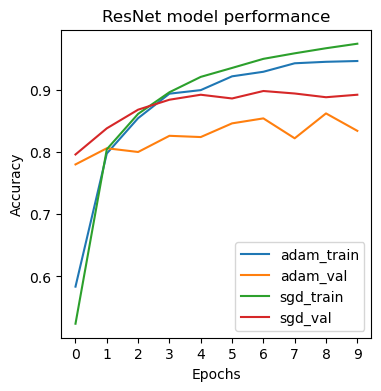

In [18]:
plt.figure(figsize=(4,4))
plt.plot(history_res_adam.history['accuracy'], label='adam_train')
plt.plot(history_res_adam.history['val_accuracy'], label='adam_val')
plt.plot(history_res_sgd.history['accuracy'], label='sgd_train')
plt.plot(history_res_sgd.history['val_accuracy'], label='sgd_val')
plt.xticks(np.arange(10))
plt.title('ResNet model performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For ResNet50, there exists a gap between Training and Validation performance while being lower than MobileNetV2.

### Using MobileNetV2 - Adjusting Learning Rate

We shall try to adjust learning rates to check if performance can be improved further. We will also incorporate checkpointing to save the best performers.

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [24]:
def make_model(learning_rate=0.01):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(100)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [26]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/mobilenetv2_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [28]:
scores = {}

for lr in [0.005, 0.01, 0.05]:
    print(f'Testing with learning rate: {lr}')

    model = make_model(learning_rate=lr)
    print(model.summary())
    print()
    history = model.fit(
        train_ds, 
        epochs=10, 
        validation_data=val_ds, 
        callbacks=[checkpoint]
    )
    scores[lr] = history.history
    print('###############################################################')

Testing with learning rate: 0.005
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 100)               128100    
                                                                 
Total params: 2,386,084
Trainable params: 128,100
Non-trainable params: 2,257,984
_________________________________________________________________
None

Epo

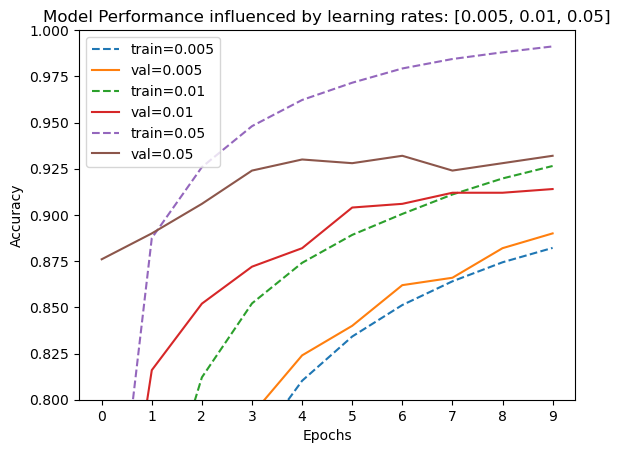

In [32]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr), linestyle='--')
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr), linestyle='-')

plt.xticks(np.arange(10))
plt.ylim([0.8, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance influenced by learning rates: [0.005, 0.01, 0.05]')
plt.legend()
plt.show()

From the plot above, we notice that: 
- For learning rate=0.05, although the performance on validation set is slightly higher, there is quite a lot of overfitting. 
- For learning rate=0.005, the model doesn't reach peak performance by 10 epochs as indicated by a slightly upward gradient of the accuracy curves.
- Learning rate=0.01, yields the best model of the three with comparable performance across training and validation sets and the accuracy curve starts flattening out at 10 epochs.

We proceed with a learning rate of 0.01

### Testing with more hidden layers

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [33]:
def make_model(learning_rate=0.01, num_neurons=10):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    hidden = keras.layers.Dense(num_neurons, activation='relu')(vectors)
    outputs = keras.layers.Dense(100)(hidden)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [42]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/mobilenetv2_v2_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [44]:
# scores = {}

for size in [1000]:
    print(f'Testing with {size} neurons in inner hidden layer')

    model = make_model(num_neurons=size)
#     print(model.summary())
    print()
    history = model.fit(
        train_ds, 
        epochs=10, 
        validation_data=val_ds, 
        callbacks=[checkpoint]
    )
    scores[size] = history.history
    print('#####################################################################################################')

Testing with 1000 neurons in inner hidden layer

Epoch 1/10
422/422 [==============================] - 28s 63ms/step - loss: 2.8930 - accuracy: 0.4270 - val_loss: 1.4420 - val_accuracy: 0.7260
Epoch 2/10
422/422 [==============================] - 25s 60ms/step - loss: 1.0314 - accuracy: 0.7974 - val_loss: 0.7258 - val_accuracy: 0.8600
Epoch 3/10
422/422 [==============================] - 26s 61ms/step - loss: 0.6451 - accuracy: 0.8629 - val_loss: 0.5151 - val_accuracy: 0.8920
Epoch 4/10
422/422 [==============================] - 25s 59ms/step - loss: 0.4884 - accuracy: 0.8919 - val_loss: 0.4486 - val_accuracy: 0.8920
Epoch 5/10
422/422 [==============================] - 26s 61ms/step - loss: 0.3982 - accuracy: 0.9132 - val_loss: 0.3791 - val_accuracy: 0.9040
Epoch 6/10
422/422 [==============================] - 25s 60ms/step - loss: 0.3368 - accuracy: 0.9308 - val_loss: 0.3531 - val_accuracy: 0.9000
Epoch 7/10
422/422 [==============================] - 26s 61ms/step - loss: 0.2927 - ac

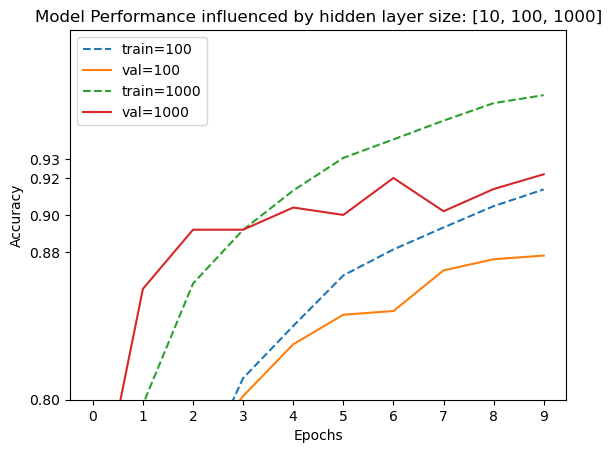

In [49]:
if 10 in scores.keys():
    del scores[10]

for size, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % size), linestyle='--')
    plt.plot(hist['val_accuracy'], label=('val=%s' % size), linestyle='-')

plt.xticks(np.arange(10))
plt.yticks([0.8, 0.88, 0.9, 0.92, 0.93])
plt.ylim([0.8, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance influenced by hidden layer size: [10, 100, 1000]')
plt.legend()
plt.show()

From the plot above, we can infer that with addition of a new layer of neurons in the architecture does not yield much to the performance of the model, while increasing model complexity. Only a 0.01 percent improve in validation accuracy over a standard model. Hence, we proceed with a standard model found in the previous step.

- Learning rate = 0.01
- No hidden layer

As our current model also less variance between training and validation datasets, we can skip the regularization step.
Next, we try freeze some parts of our data to train our model.

### Dropout

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [6]:
def make_model(learning_rate=0.01, droprate=0.5):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    drop = keras.layers.Dropout(droprate)(vectors)
    outputs = keras.layers.Dense(100)(drop)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [7]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/mobilenetv2_v3_droprate_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [8]:
# Create training set

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(224, 224),
    batch_size=32
)

# Create validation set

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    '../data/valid',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [16]:
scores = {}

for rate in [0.0, 0.2, 0.5, 0.8]:
    print(f'Testing with droprate: {rate}')

    model = make_model(droprate=rate)
    print()
    history = model.fit(
        train_ds, 
        epochs=30, 
        validation_data=val_ds, 
        callbacks=[checkpoint]
    )
    scores[rate] = history.history
    print('#####################################################################################################')

Testing with droprate: 0.0

Epoch 1/30
422/422 [==============================] - 27s 58ms/step - loss: 3.2330 - accuracy: 0.3382 - val_loss: 1.9734 - val_accuracy: 0.6560
Epoch 2/30
422/422 [==============================] - 25s 59ms/step - loss: 1.5435 - accuracy: 0.7272 - val_loss: 1.1350 - val_accuracy: 0.8120
Epoch 3/30
422/422 [==============================] - 24s 57ms/step - loss: 1.0227 - accuracy: 0.8204 - val_loss: 0.8281 - val_accuracy: 0.8580
Epoch 4/30
422/422 [==============================] - 25s 58ms/step - loss: 0.7935 - accuracy: 0.8561 - val_loss: 0.6726 - val_accuracy: 0.8800
Epoch 5/30
422/422 [==============================] - 24s 56ms/step - loss: 0.6629 - accuracy: 0.8768 - val_loss: 0.5790 - val_accuracy: 0.8920
Epoch 6/30
422/422 [==============================] - 25s 59ms/step - loss: 0.5769 - accuracy: 0.8930 - val_loss: 0.5153 - val_accuracy: 0.9100
Epoch 7/30
422/422 [==============================] - 23s 55ms/step - loss: 0.5134 - accuracy: 0.9035 - val_

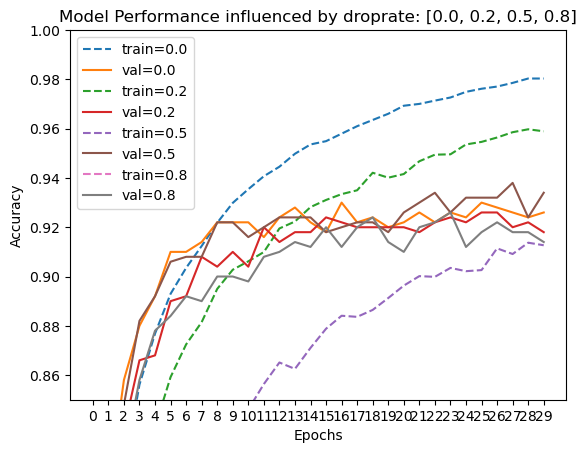

In [18]:
for rate, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % rate), linestyle='--')
    plt.plot(hist['val_accuracy'], label=('val=%s' % rate), linestyle='-')

plt.xticks(np.arange(30))
# plt.yticks([0.8, 0.88, 0.9, 0.92, 0.93])
plt.ylim([0.85, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance influenced by droprate: [0.0, 0.2, 0.5, 0.8]')
plt.legend()
plt.show()

After 10 epochs, the performance at 20% drop rate provides improved performance and comparable across train and validation sets.

### Data Augmentation

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

In [10]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    width_shift_range=0.2,
    vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(224, 224),
    batch_size=32
)

# Create validation set

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    '../data/valid',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [11]:
def make_model(learning_rate=0.01, droprate=0.2):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    drop = keras.layers.Dropout(droprate)(vectors)
    outputs = keras.layers.Dense(100)(drop)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/mobilenetv2_v4_aug_width_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [14]:
scores = {}
learning_rate = 0.01
droprate = 0.2

print(f'Testing with Data Augmentations')
print('-'*100)

model = make_model(learning_rate=learning_rate,droprate=droprate)

history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=val_ds, 
    callbacks=[checkpoint]
)
scores[aug] = history.history

Testing with Data Augmentations
----------------------------------------------------------------------------------------------------
Epoch 1/30
422/422 [==============================] - 150s 350ms/step - loss: 3.8189 - accuracy: 0.1654 - val_loss: 2.4836 - val_accuracy: 0.4780
Epoch 2/30
422/422 [==============================] - 147s 348ms/step - loss: 2.3179 - accuracy: 0.4735 - val_loss: 1.5514 - val_accuracy: 0.6820
Epoch 3/30
422/422 [==============================] - 148s 351ms/step - loss: 1.7430 - accuracy: 0.5918 - val_loss: 1.1689 - val_accuracy: 0.7680
Epoch 4/30
422/422 [==============================] - 146s 346ms/step - loss: 1.4324 - accuracy: 0.6595 - val_loss: 0.9552 - val_accuracy: 0.7900
Epoch 5/30
422/422 [==============================] - 148s 350ms/step - loss: 1.2497 - accuracy: 0.6974 - val_loss: 0.8246 - val_accuracy: 0.8160
Epoch 6/30
422/422 [==============================] - 147s 348ms/step - loss: 1.1355 - accuracy: 0.7198 - val_loss: 0.7346 - val_accuracy

NameError: name 'aug' is not defined

With width wise augmented data, we do not see improvements in performance. Let's try with height_shift.

In [7]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    height_shift_range=0.2,
)

train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(224, 224),
    batch_size=32
)

# Create validation set

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    '../data/valid',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [8]:
def make_model(learning_rate=0.01, droprate=0.2):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    drop = keras.layers.Dropout(droprate)(vectors)
    outputs = keras.layers.Dense(100)(drop)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [9]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/mobilenetv2_v5_aug_height_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [10]:
learning_rate = 0.01
droprate = 0.2

print(f'Testing with Data Augmentations')
print('-'*100)

model = make_model(learning_rate=learning_rate,droprate=droprate)

history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=val_ds, 
    callbacks=[checkpoint]
)

Testing with Data Augmentations
----------------------------------------------------------------------------------------------------


2023-12-16 05:31:45.622515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-16 05:31:45.629103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-16 05:31:45.629745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-16 05:31:45.630630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/30


2023-12-16 05:31:51.434168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-16 05:31:52.071537: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 05:31:52.071973: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 05:31:52.072010: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-16 05:31:52.072516: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-16 05:31:52.072618: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


422/422 [==============================] - 150s 346ms/step - loss: 3.3946 - accuracy: 0.2686 - val_loss: 2.0824 - val_accuracy: 0.6040
Epoch 2/30
422/422 [==============================] - 138s 327ms/step - loss: 1.7724 - accuracy: 0.6315 - val_loss: 1.2161 - val_accuracy: 0.7800
Epoch 3/30
422/422 [==============================] - 137s 324ms/step - loss: 1.2393 - accuracy: 0.7337 - val_loss: 0.8924 - val_accuracy: 0.8220
Epoch 4/30
422/422 [==============================] - 137s 324ms/step - loss: 0.9840 - accuracy: 0.7831 - val_loss: 0.7225 - val_accuracy: 0.8540
Epoch 5/30
422/422 [==============================] - 138s 326ms/step - loss: 0.8521 - accuracy: 0.8068 - val_loss: 0.6163 - val_accuracy: 0.8780
Epoch 6/30
422/422 [==============================] - 137s 325ms/step - loss: 0.7472 - accuracy: 0.8286 - val_loss: 0.5566 - val_accuracy: 0.8900
Epoch 7/30
422/422 [==============================] - 137s 325ms/step - loss: 0.6854 - accuracy: 0.8386 - val_loss: 0.5073 - val_accura

KeyboardInterrupt: 

From augmenting height of the images, very little benefit to the accuracy is achieved. However, we get a more regularised model.

In [14]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=15
)

train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(224, 224),
    batch_size=32
)

# Create validation set

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_ds = val_gen.flow_from_directory(
    '../data/valid',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [15]:
def make_model(learning_rate=0.01, droprate=0.2):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    drop = keras.layers.Dropout(droprate)(vectors)
    outputs = keras.layers.Dense(100)(drop)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [16]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/mobilenetv2_v6_aug_rot_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [17]:
learning_rate = 0.01
droprate = 0.2

print(f'Testing with Data Augmentations')
print('-'*100)

model = make_model(learning_rate=learning_rate,droprate=droprate)

history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=val_ds, 
    callbacks=[checkpoint]
)

Testing with Data Augmentations
----------------------------------------------------------------------------------------------------
Epoch 1/30
422/422 [==============================] - 139s 324ms/step - loss: 3.4862 - accuracy: 0.2490 - val_loss: 2.1320 - val_accuracy: 0.5900
Epoch 2/30
422/422 [==============================] - 137s 325ms/step - loss: 1.8077 - accuracy: 0.6158 - val_loss: 1.2667 - val_accuracy: 0.7620
Epoch 3/30
422/422 [==============================] - 136s 322ms/step - loss: 1.2516 - accuracy: 0.7299 - val_loss: 0.9254 - val_accuracy: 0.8200
Epoch 4/30
422/422 [==============================] - 136s 321ms/step - loss: 1.0039 - accuracy: 0.7769 - val_loss: 0.7530 - val_accuracy: 0.8480
Epoch 5/30
422/422 [==============================] - 138s 327ms/step - loss: 0.8636 - accuracy: 0.8020 - val_loss: 0.6585 - val_accuracy: 0.8660
Epoch 6/30
422/422 [==============================] - 136s 322ms/step - loss: 0.7651 - accuracy: 0.8204 - val_loss: 0.5861 - val_accuracy

KeyboardInterrupt: 

Using rotation as an augmentation technique, we get similar results to height augmentations. We shall use height and rotation augmentations. 

We will proceed with training on the full train including train and valid sets.

### Training model on full train - train + valid

In [18]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '../models/mobilenetv2_v7_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    start_from_epoch=10,
)

TypeError: __init__() got an unexpected keyword argument 'start_from_epoch'

In [ ]:
# Define the data generators
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=15,
    height_shift_range=0.2    
)

valid_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rotation_range=15,
    height_shift_range=0.2
)

# Create the training and validation data generators
train_ds = train_gen.flow_from_directory(
    '../data/train',
    target_size=(224, 224),
    batch_size=32
)

validation_generator = valid_datagen.flow_from_directory(
    '../data/valid',
    target_size=(224, 224),
    batch_size=32,
)

# Combine the training and validation data generators
full_train_generator = keras.preprocessing.image.ImageDataGenerator().flow(
    train_ds.filenames + validation_ds.filenames,
    train_ds.target_size,
    train_ds.batch_size,
    shuffle=True)
    
# Create the model
model = make_model(learning_rate=learning_rate, 
                   droprate=droprate)

# Monitor the scores achieved
scores = []
    
# Train the model
history = model.fit_generator(
    full_train_generator,
    steps_per_epoch=len(train_ds.filenames) // train_ds.batch_size,
    epochs=30,
    callbacks=[checkpoint, early_stop]
)
    
# Append to scores
scores.append(history.history)